In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import pyspark
from pyspark import SparkContext, SQLContext
from scipy.sparse import csr_matrix
import random

In [3]:
ratings = pd.read_csv('ml-20m/ratings.csv', header=0)

### 1. Plot the counts of each rating

In [59]:
# get count
ratings_cnt_tmp = pd.DataFrame(ratings.groupby('rating').size(),columns=['count1'])
summ = ratings_cnt_tmp.count1.sum()

In [94]:
ratings_cnt_tmp

,count1
rating,
0.5,239125
1.0,680732
1.5,279252
2.0,1430997
2.5,883398
3.0,4291193
3.5,2200156
4.0,5561926
4.5,1534824


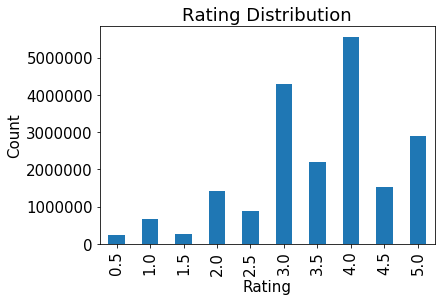

In [45]:
# EDA on counts excluding 0 or NaN
plt.rc("font",size =15)
ratings_cnt_tmp.count1.plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

#### From this rough exploration, we noticed that there are comparatively more 4.0 and 3.0 ratings in this data set, with 4.0 being the most frequent rating to be rated by users.

In [120]:
# by adding the counts of rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - ratings.shape[0]
ratings_cnt = ratings_cnt_tmp.append(pd.DataFrame({'count1':rating_zero_cnt},index=[0.0]),
                                    verify_integrity = True).sort_index()
ratings_cnt

,count1
0.0,3683856529
0.5,239125
1.0,680732
1.5,279252
2.0,1430997
2.5,883398
3.0,4291193
3.5,2200156
4.0,5561926
4.5,1534824


In [121]:
# take log
ratings_cnt['log_count'] = np.log(ratings_cnt['count1'])
ratings_cnt

,count1,log_count
0.0,3683856529,22.027226
0.5,239125,12.384742
1.0,680732,13.430924
1.5,279252,12.539870
2.0,1430997,14.173882
2.5,883398,13.691531
3.0,4291193,15.272075
3.5,2200156,14.604039
4.0,5561926,15.531455
4.5,1534824,14.243926


Text(0, 0.5, 'number of ratings (in Log Scale)')

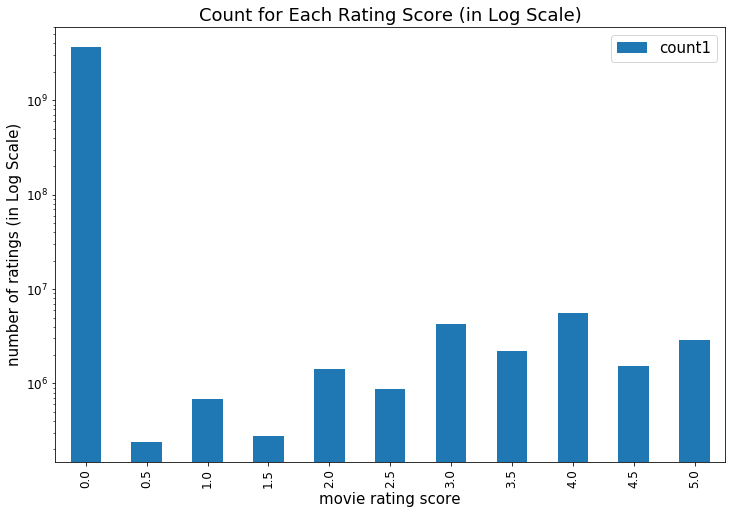

In [127]:
ax = ratings_cnt[['count1']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count1',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings (in Log Scale)")

#### 2. plot rating frequency of all movies

In [95]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [96]:
# get rating frequency
ratings_movie = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
ratings_movie.head()

,count
movieId,
1,49695
2,22243
3,12735
4,2756
5,12161


Text(0, 0.5, 'number of ratings')

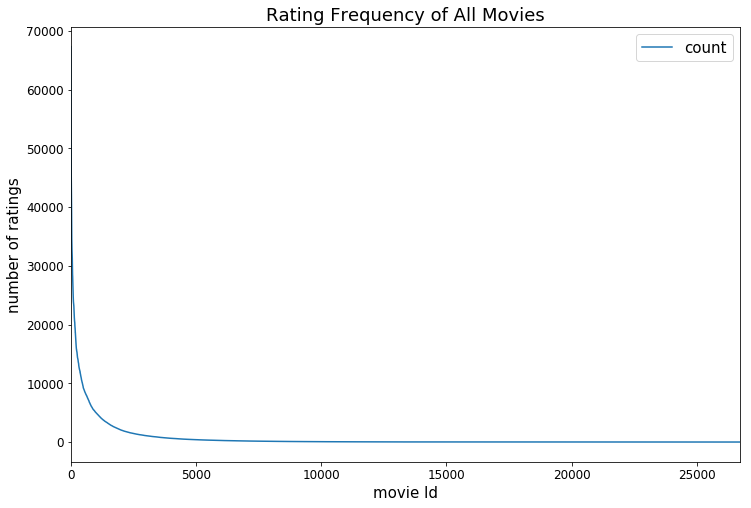

In [97]:
# plot rating frequency of all movies
ax = ratings_movie \
     .sort_values('count',ascending = False)\
    .reset_index(drop = True)\
    .plot(figsize = (12,8),
         title = 'Rating Frequency of All Movies',
         fontsize = 12)
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

##### the distribution of ratings among movies satisfy the long-tail property, which says only a small portion of the items are rated frequently. Such items are then popular items, and the vast majority are rated rarely. This results in a highly skewed distribution.

Text(0, 0.5, 'number of ratings (log scale)')

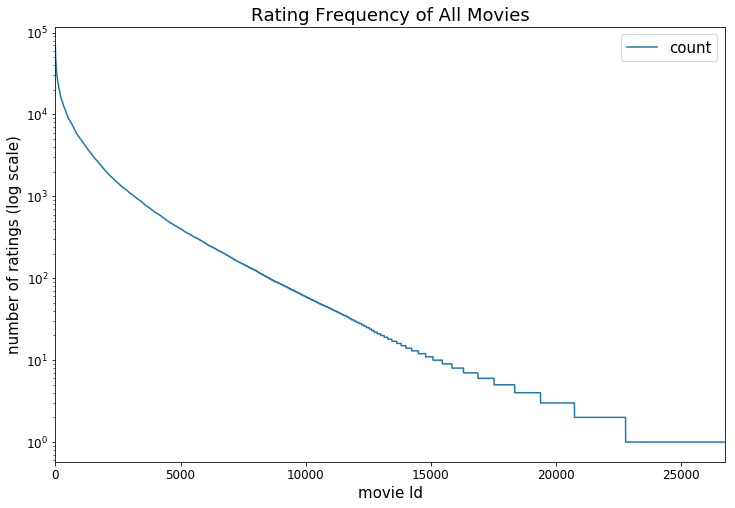

In [100]:
# if after log scale
ax = ratings_movie \
     .sort_values('count',ascending = False)\
    .reset_index(drop = True)\
    .plot(figsize = (12,8),
         title = 'Rating Frequency of All Movies',
         fontsize = 12,
         logy=True)
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

##### About 10,000 out of 26,744 movies are rated more than 100 times. About 10,000 out of 26,744 movies are rated less than 10 times.

In [126]:
ratings_movie['count'].describe()

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: count, dtype: float64

In [102]:
ratings_movie['count'].quantile(np.arange(1,0.6,-0.05))

1.00    67310.00
0.95     3612.95
0.90     1305.70
0.85      632.55
0.80      346.00
0.75      205.00
0.70      123.00
0.65       74.00
Name: count, dtype: float64

##### About 1% of movies have 67,310 or more ratings, 5% have 3,612 or more, and 20% have 346 or more.

In [103]:
# plot rating frequency of all users
ratings_user = pd.DataFrame(ratings.groupby('userId').size(), columns = ['count'])
ratings_user.head()

,count
userId,
1,175
2,61
3,187
4,28
5,66


Text(0, 0.5, 'number of ratings')

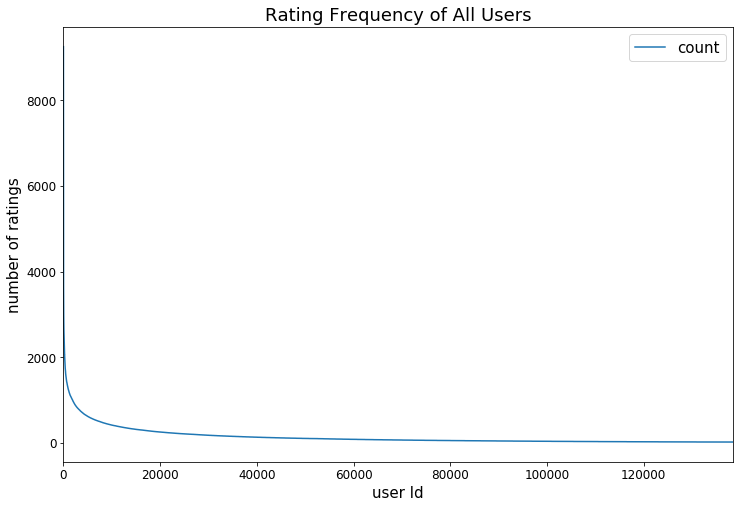

In [105]:
# cont.
ax = ratings_user \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

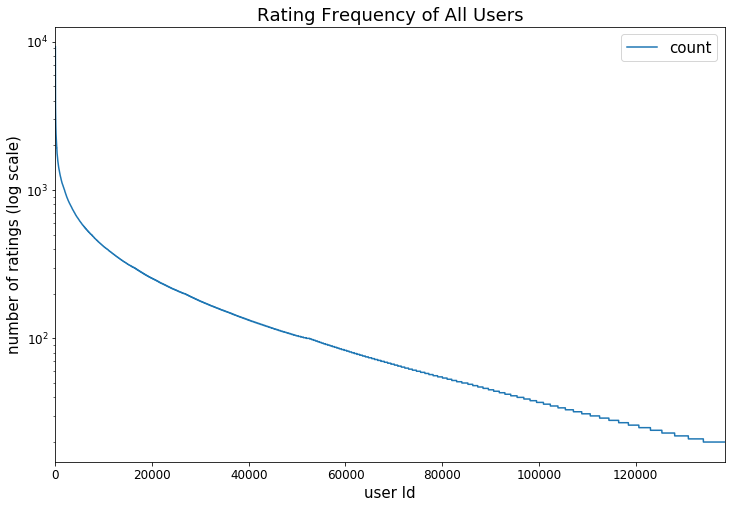

In [107]:
# log it
ax = ratings_user \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12,
        logy = True
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings (log scale)")

In [108]:
ratings_user['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    9254.0
0.95     520.0
0.90     334.0
0.85     246.0
0.80     193.0
0.75     155.0
0.70     127.0
0.65     108.0
0.60      93.0
0.55      79.0
Name: count, dtype: float64

##### For users, the distribution is very similar to that of the movies. They both have long-tail property. Only a small portion of users are actively rating movies, with vast majority being uninterested in rating.

#### 3. calculate matrix sparsity

In [113]:
# based on our analysis, let's drop 75% of movies in our dataset to reduce size.
popularity_thres = 200
popular_movies = list(set(ratings_movie.query('count>=@popularity_thres').index))
new_ratings_movie = ratings[ratings.movieId.isin(popular_movies)]

In [115]:
# and limit to top 40% users
user_thres = 90
active = list(set(ratings_user.query('count >= @user_thres').index))
new_new_ratings_movie = new_ratings_movie[new_ratings_movie.userId.isin(active)]

In [116]:
movie_user_mtx = new_new_ratings_movie.pivot(index='movieId', columns='userId', values='rating').fillna(0)

In [118]:
# calculate sparsity

num_entries = movie_user_mtx.shape[0] * movie_user_mtx.shape[1]
num_zeros = (movie_user_mtx==0).sum(axis=1).sum()
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 95.85% of ratings in our data is missing


### another way i guess?

#### get new column total rating count, and get stats

In [ ]:
group by user, count distinct movies they rated
group by count, count distinct users

In [70]:
user_ratingCount = (ratings.groupby(by=['userId'])['movieId'].
                   count().
                   reset_index().
                   rename(columns = {'movieId':'distinctMovies'})
                   [['userId','distinctMovies']])
user_ratingCount.head(10)

,userId,distinctMovies
0,1,175
1,2,61
2,3,187
3,4,28
4,5,66
5,6,24
6,7,276
7,8,70
8,9,35
9,10,38


In [81]:
distinct_user = (user_ratingCount.groupby(by=['distinctMovies'])['userId'].
                count().
                reset_index().
                rename(columns={'userId':'distinctUsers'})
                [['distinctMovies','distinctUsers']])
distinct_user.head(10)

,distinctMovies,distinctUsers
0,20,4485
1,21,3104
2,22,2832
3,23,2641
4,24,2365
5,25,2399
6,26,2164
7,27,2016
8,28,2016
9,29,1922


In [84]:
b = pd.Series(distinct_user.distinctUsers, index=distinct_user.distinctMovies).to_dict()

<BarContainer object of 1897 artists>

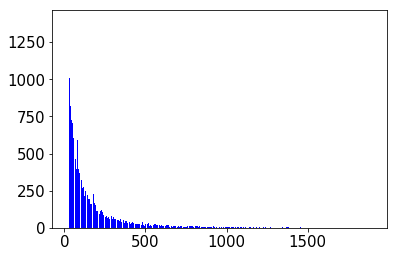

In [86]:
plt.bar(list(b.keys()),b.values(),color = 'b')

In [87]:
distinct_user.describe()

,distinctMovies,distinctUsers
count,1897.000000,1897.000000
mean,1107.582499,73.006326
std,852.243797,265.913216
min,20.000000,1.000000
25%,494.000000,1.000000
50%,968.000000,5.000000
75%,1487.000000,27.000000
max,9254.000000,4485.000000


In [89]:
print(distinct_user['distinctUsers'].quantile(np.arange(.9,1,.01)))

0.90     135.40
0.91     157.36
0.92     182.96
0.93     226.28
0.94     271.96
0.95     349.40
0.96     461.80
0.97     596.08
0.98     877.60
0.99    1341.20
Name: distinctUsers, dtype: float64


In [10]:
movie_ratingCount = (ratings.groupby(by=['movieId'])['rating'].
                     count().
                     reset_index().
                     rename(columns={'rating':'totalRatingCount'})
                     [['movieId','totalRatingCount']]
                    )
movie_ratingCount.head(10)

,movieId,totalRatingCount
0,1,49695
1,2,22243
2,3,12735
3,4,2756
4,5,12161
5,6,23899
6,7,12961
7,8,1415
8,9,3960
9,10,29005


In [11]:
rating_with_total = ratings.merge(movie_ratingCount, left_on = 'movieId', right_on='movieId', how='left')

In [12]:
rating_with_total.head(10)

,userId,movieId,rating,timestamp,totalRatingCount
0,1,2,3.5,1112486027,22243
1,1,29,3.5,1112484676,8520
2,1,32,3.5,1112484819,44980
3,1,47,3.5,1112484727,43249
4,1,50,3.5,1112484580,47006
5,1,112,3.5,1094785740,11890
6,1,151,4.0,1094785734,12616
7,1,223,4.0,1112485573,23695
8,1,253,4.0,1112484940,27568
9,1,260,4.0,1112484826,54502


#### stats of total rating count

In [13]:
pd.set_option('display.float_format',lambda x: '%.3f' %x)
print(movie_ratingCount['totalRatingCount'].describe())

count   26744.000
mean      747.841
std      3085.818
min         1.000
25%         3.000
50%        18.000
75%       205.000
max     67310.000
Name: totalRatingCount, dtype: float64


#### The median movie has been rated 18 times.

#### top of the distribution

In [34]:
print(movie_ratingCount['totalRatingCount'].quantile(np.arange(.9,1,.01)))

0.900    1305.700
0.910    1543.000
0.920    1848.000
0.930    2285.980
0.940    2847.000
0.950    3612.950
0.960    4700.560
0.970    6219.970
0.980    8835.780
0.990   14388.690
Name: totalRatingCount, dtype: float64


#### about 1+% of the movies have rating counts more than 10k, which will give us about 2674 unique movie

In [35]:
popularity_threshold = 10000
rating_popular_movie = rating_with_total.query('totalRatingCount >= @popularity_threshold')
rating_popular_movie.head(10)

,userId,movieId,rating,timestamp,totalRatingCount
0,1,2,3.500,1112486027,22243
2,1,32,3.500,1112484819,44980
3,1,47,3.500,1112484727,43249
4,1,50,3.500,1112484580,47006
5,1,112,3.500,1094785740,11890
6,1,151,4.000,1094785734,12616
7,1,223,4.000,1112485573,23695
8,1,253,4.000,1112484940,27568
9,1,260,4.000,1112484826,54502
10,1,293,4.000,1112484703,25804
